<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Introduction

The Cook County housing market is a complex ecosystem influenced by a myriad of factors. In this project, we delve into the realm of data science to analyze and understand this market better. Our journey begins with Exploratory Data Analysis (EDA), where we unravel the structure of the housing data to uncover patterns, trends, and anomalies.

With a thorough understanding of the data, we transition into the realm of predictive modeling. Leveraging the power of linear regression, we construct a model aimed at predicting housing prices based on various features. This model serves as a foundational tool for understanding the dynamics of the Cook County housing market and aids in making informed decisions.

However, the journey doesn't end here. We meticulously analyze the errors in our model, seeking opportunities for enhancement. Through iterative refinement and feature engineering, we strive to improve the model's performance, aiming for higher accuracy and predictive power.

Join us on this data-driven exploration of the Cook County housing market, where every insight gained brings us closer to unraveling its intricate dynamics.

In [2]:
""" 
For this project, we will utilize the numpy and pandas libraries for data manipulation, 
along with Matplotlib and Seaborn for data visualization.
"""
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total. An explanation of each variable can be found in the included `CookCountyDataCodebook.txt` file .

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but we will only be working on the training set for this part of the project.

Let's first extract the data from the `cook_county_data.zip`. Just run the cells below: 

In [3]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

Now, let's load the training data.

In [4]:
training_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')

As a sanity check, we should verify that the data shape matches the description.

In [5]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

The next order of business is getting a feel for the variables in our data.  A more detailed description of each variable is included in `CookCountyDataCodebook.txt` (in the same directory as this notebook). 

Let's take a quick look at all the current columns in our training data.

In [6]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

This data set was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home . You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). In the later part of this project we will be building a linear model that predict sales prices using training data but it's important to first understand how the structure of the data informs such a model. In this section, we will make a series of exploratory visualizations and feature engineering in preparation for that prediction task.

### Sale Price
We begin by examining the distribution of our target variable `Sale Price`. We have created a helper method `plot_distribution` that one can use to visualize the distribution of the `Sale Price` using both the histogram and the box plot at the same time.

In [7]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

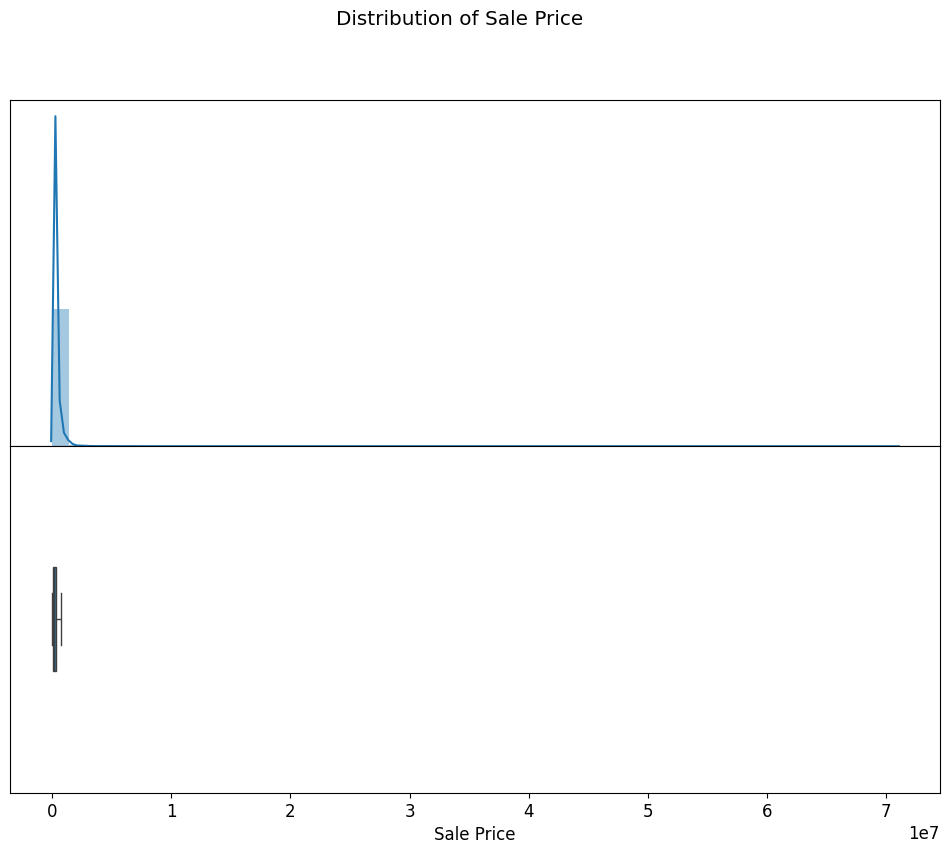

In [8]:
plot_distribution(training_data, label='Sale Price')

<br/>
<hr style="border: 1px solid #fdb515;" />

At the same time, we can also take a look at some descriptive statistics of the Sale Price.

In [9]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

Taking a look at the distribution plot and the descriptive statistics, we can see a significant right skew cause by really large values in the sale price. To account for this It would be best to transform the sale price into the log of the sale price to decrease the range of sale prices to be smaller and on a similar order of magnitude.

<br/>
<hr style="border: 1px solid #fdb515;" />

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price` for this analysis. In addition, it would be a good idea to apply log transformation to `Sale Price`. In the cell below, we will reassign `training_data` to a new dataframe that is the same as the original one **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.


**Note**: This also implies from now on, our target variable in the model will be the log-transformed sale prices from the column `Log Sale Price`. 

In [10]:
five_hundered_dollar_filter = training_data['Sale Price'] >= 500
training_data = training_data[five_hundered_dollar_filter]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

Let's create a new distribution plot on the log-transformed sale price.


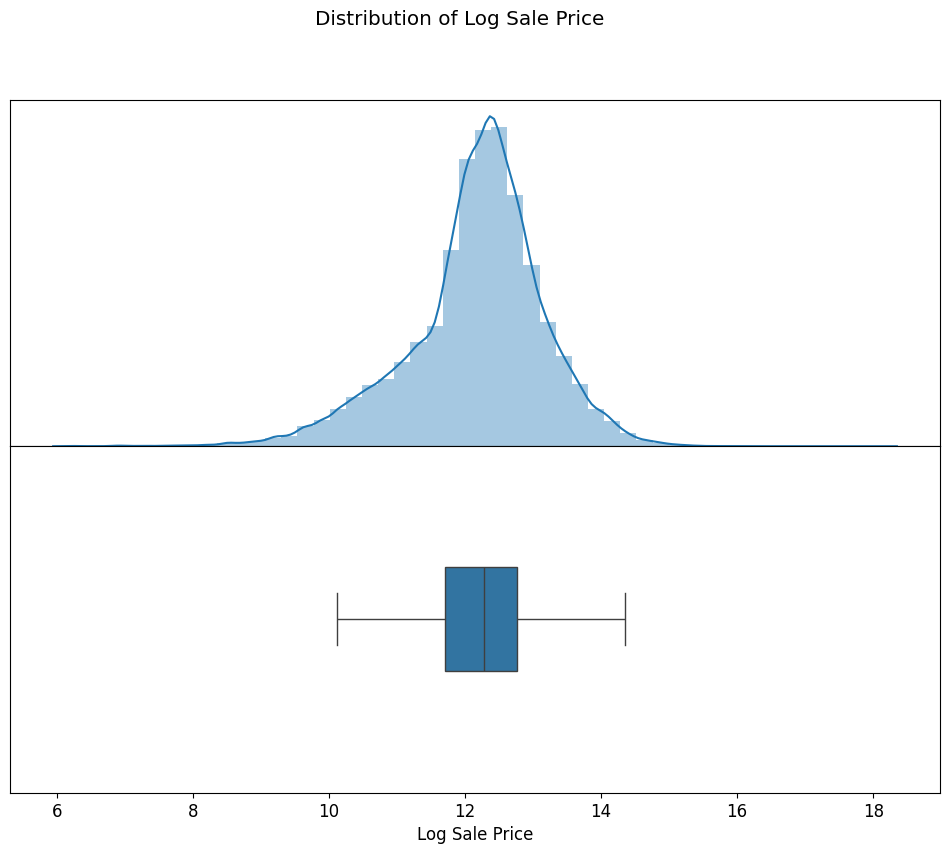

In [11]:
plot_distribution(training_data, label='Log Sale Price')

<br/>
<hr style="border: 1px solid #fdb515;" />



A good question to get an idea of the price of homes is to ask whether it is true or false that at least 25% of the properties in the training set sold for more than $200,000.00. One way to check this is by using np.percentile for 75% and checking if it's greater than $200,000.

In [12]:
print(np.percentile(training_data['Sale Price'],75) > 200_000)

True


Next, we want to explore if there is any correlation between `Log Sale Price` and the total area occupied by the property. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Let's also apply a log transformation to the `Building Square Feet` column.

In [13]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

Now let's create a a `jointplot` with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis to see if `Log Building Square Feet` would make a good candidate as one of the features for our model.

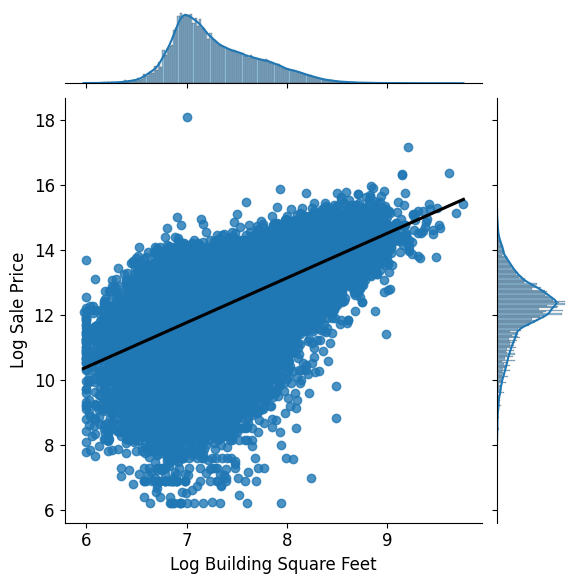

In [16]:
sns.jointplot(data=training_data, x='Log Building Square Feet', y='Log Sale Price', kind='reg', joint_kws={'line_kws':{'color':'black'}})

The plot shows that the `Log Building Square Feet` would make a decent candidate as one of the features. Still, further transformations could be applied to 'linearize' the relationship between the two. They show potential because the residuals hover around 0 with values on both sides through the axis. This feature needs further work because the model tends to over-predict prices for smaller buildings and under-predict prices for larger structures.    

 As we explore the dataset further, we might still run into more outliers that prevent us from creating a clear visualization or capturing the trend of the majority of the houses. To address this issue we should create a function that will work to remove these outliers from the data as we run into them.

In [ ]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
    data (data frame): the table to be filtered
    variable (string): the column with numerical outliers
    lower (numeric): observations with values lower than this will be removed
    upper (numeric): observations with values higher than this will be removed
    
    Output:
    a data frame with outliers removed
    
    Note: This function should not change mutate the contents of data.
    """  
    lower_filter = data[variable] >= lower
    upper_filter = data[variable] <= upper
    return data[lower_filter & upper_filter]

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original `DataFrame`! Instead, it is part of the `Description` column.

<br><br>

---

Let's take a closer look at the `Description` column first.

In [17]:
# Print out Description column and notice where/how bathrooms are saved:
print(training_data["Description"][1])
print("")
print(training_data["Description"][60])

This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.

This property, sold on 10/11/2016, is a two-story houeshold located at 123 S LANCASTER AVE.It has a total of 9 rooms, 4 of which are bedrooms, and 2.5 of which are bathrooms.


Notice the number of bathrooms always shows up in the following statement "and x.y of which are bathrooms." 

Wait, why are these floating point numbers?  Here's how full versus half bathrooms are defined:
 - A full bathroom consists of four main elements — a sink, toilet, shower, and bathtub. 
 - A half-bath is a bathroom that contains two of the four elements, usually a sink and toilet, though in some cases a half-bath could just contain a shower and tub. 


To extract "x.y" as a float from the description column, we can use the following Regular Expression:


`bedrooms_regex = r'(\d) of which are bathrooms'`
 
 We can then use [str.extract](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.extract.html) to output this information:

 Now, let's write a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the **total number of bedrooms (as integers)** for each house and treat missing values as zeros, if necessary.

In [21]:
def add_total_bedrooms(data):
    """
    Input:
    data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex_1 = r'(\d) of which are bedrooms' 
    with_rooms['Bedrooms'] = data["Description"].str.extract(rooms_regex_1).astype(float)
    with_rooms.fillna(0,inplace = True)
    with_rooms['Bedrooms'] = with_rooms['Bedrooms'].astype(int)
    
    return with_rooms

training_data = add_total_bedrooms(training_data)